# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [1]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [2]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [3]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [4]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [5]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [35]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [57]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, 
                scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.cuda()#.to(device)
            y_gpu = y.cuda()#.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
            
        if scheduler is not None:
            # Decay Learning Rate
            print('Epoch:', epoch,'LR:', 
                  [pg['lr'] for pg in optimizer.param_groups])#scheduler.get_lr())
            scheduler.step()
            
        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader, use_gpu=True)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Epoch: %d, Average loss: %f, Train accuracy: %f, Val accuracy: %f" % \
                (epoch, ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader, use_gpu=False):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    correct_samples = 0
    total_samples = 0
    for i_step, (x, y) in enumerate(loader):
        if use_gpu:
            x = x.cuda()
            y = y.cuda()            
        prediction = model(x)    
            
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]    
    
    return float(correct_samples) / total_samples

In [37]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Epoch: 0, Average loss: 1.368979, Train accuracy: 0.544023, Val accuracy: 0.748140
Epoch: 1, Average loss: 0.690190, Train accuracy: 0.791301, Val accuracy: 0.775988
Epoch: 2, Average loss: 0.589990, Train accuracy: 0.823653, Val accuracy: 0.828135
Epoch: 3, Average loss: 0.537732, Train accuracy: 0.840204, Val accuracy: 0.837076
Epoch: 4, Average loss: 0.508874, Train accuracy: 0.848940, Val accuracy: 0.847041


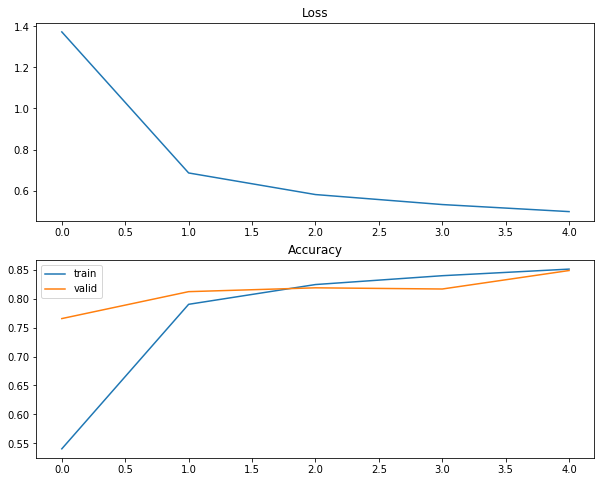

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8))
ax[0].plot(loss_history)
ax[1].plot(train_history, label='train')
ax[1].plot(val_history, label='valid')
ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
plt.legend()
plt.show()

# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [9]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./data/', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

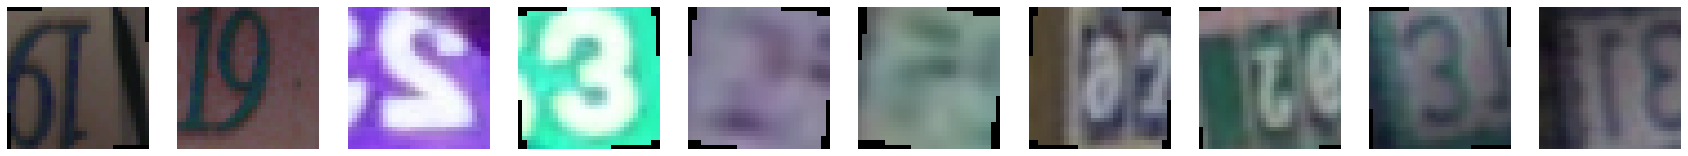

In [10]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./data/', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

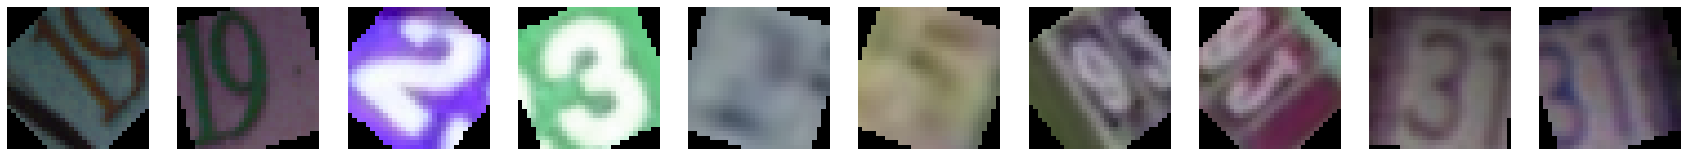

In [93]:
# TODO: 
tfs = transforms.Compose([
    # TODO: Add good augmentations
    transforms.RandomCrop(size=32),
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    #transforms.ToTensor(),
    #transforms.Normalize(mean=[0.43,0.44,0.47],
                       #std=[0.20,0.20,0.20])                           
])

# TODO create new instances of loaders with the augmentations you chose
data_aug_train =  dset.SVHN('./data/', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_train):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

In [17]:
%%time
# Finally, let's train with augmentations!
# TODO: 
tfs = transforms.Compose([
    # TODO: Add good augmentations
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# TODO create new instances of loaders with the augmentations you chose
data_aug_train =  dset.SVHN('./data/', 
                       transform=tfs
                      )
train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                               sampler=train_sampler)
# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Epoch: 0, Average loss: 1.343473, Train accuracy: 0.561393, Val accuracy: 0.720156
Epoch: 1, Average loss: 0.996578, Train accuracy: 0.677064, Val accuracy: 0.720770
Epoch: 2, Average loss: 0.913479, Train accuracy: 0.706020, Val accuracy: 0.765886
Epoch: 3, Average loss: 0.866423, Train accuracy: 0.722417, Val accuracy: 0.760767
Epoch: 4, Average loss: 0.837563, Train accuracy: 0.732502, Val accuracy: 0.686028
CPU times: user 1min 53s, sys: 833 ms, total: 1min 54s
Wall time: 1min 54s


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [24]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
    nn.Conv2d(3, 6, 5, stride=1, padding=0),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(6, 16, 5, stride=1, padding=0),
    nn.MaxPool2d(2, stride=2),   
    Flattener(),
    nn.Linear(16*5*5, 120),
    nn.Linear(120, 84),
    nn.Linear(84, 10),
)

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [25]:
%%time
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, 
                                                       val_loader, loss, optimizer, 10)

Epoch: 0, Average loss: 1.696324, Train accuracy: 0.423199, Val accuracy: 0.586376
Epoch: 1, Average loss: 1.248226, Train accuracy: 0.604392, Val accuracy: 0.662549
Epoch: 2, Average loss: 1.191893, Train accuracy: 0.627598, Val accuracy: 0.697222
Epoch: 3, Average loss: 1.159600, Train accuracy: 0.641487, Val accuracy: 0.598730
Epoch: 4, Average loss: 1.144803, Train accuracy: 0.648193, Val accuracy: 0.664460
Epoch: 5, Average loss: 1.129906, Train accuracy: 0.653397, Val accuracy: 0.671285
Epoch: 6, Average loss: 1.118301, Train accuracy: 0.655223, Val accuracy: 0.666439
Epoch: 7, Average loss: 1.105809, Train accuracy: 0.657936, Val accuracy: 0.638796
Epoch: 8, Average loss: nan, Train accuracy: 0.235590, Val accuracy: 0.070712
Epoch: 9, Average loss: nan, Train accuracy: 0.066751, Val accuracy: 0.070712
CPU times: user 3min 43s, sys: 1.73 s, total: 3min 44s
Wall time: 3min 45s


# Подбор гиперпараметров

In [79]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well
import random 

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_coeff', 'anneal_epochs', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [1e0, 1e-1, 1e-2, 1e-3, 1e-4]
anneal_coeff = [0.1, 0.2, 0.5]
anneal_epochs = [1, 2, 4, 5, 10]
reg = [1e-3, 1e-4, 1e-5, 1e-7]

batch_size = 64
epoch_num = 20

NUM_ITERATIONS = 10
# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 

# Use grid search or random search and record all runs in run_record dictionnary 
# Important: perform search in logarithmic space!

# TODO: Your code here!

In [80]:
%%time
run_record = {} 

for iter_ in range(NUM_ITERATIONS):
    # select params randomly 
    lr_ = random.choice(learning_rates)
    ann_c_ = random.choice(anneal_coeff)
    ann_e_ = random.choice(anneal_epochs)
    reg_ = random.choice(reg)
    hp = Hyperparams(lr_, ann_c_, ann_e_, reg_)
    print('Iteration {}'.format(iter_))
    print('Params:', hp)
    
    lenet_model = nn.Sequential(
        nn.Conv2d(3, 6, 5, stride=1, padding=0),
        nn.MaxPool2d(2, stride=2),
        nn.Conv2d(6, 16, 5, stride=1, padding=0),
        nn.MaxPool2d(2, stride=2),   
        Flattener(),
        nn.Linear(16*5*5, 120),
        nn.Linear(120, 84),
        nn.Linear(84, 10),
    )
    
    lenet_model.type(torch.cuda.FloatTensor)
    lenet_model.to(device)
    # set optimazer
    loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
    optimizer = optim.Adam(lenet_model.parameters(), lr=lr_, weight_decay=reg_)
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=ann_e_, gamma=1-ann_c_)
    # train model
    loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, 
                                                       loss, optimizer, epoch_num, lr_scheduler)
    # save results
    run_res = RunResult(lenet_model, train_history, val_history, val_history[-1])
    run_record[hp] = run_res
    print(hp, '\n', run_res)
    print('***************************************\n')

Iteration 0
Params: Hyperparams(learning_rate=0.1, anneal_coeff=0.5, anneal_epochs=2, reg=1e-07)
Epoch: 0 LR: [0.1]
Epoch: 0, Average loss: 1078.316284, Train accuracy: 0.183224, Val accuracy: 0.273633
Epoch: 1 LR: [0.1]
Epoch: 1, Average loss: 1.998591, Train accuracy: 0.348155, Val accuracy: 0.464815
Epoch: 2 LR: [0.05]
Epoch: 2, Average loss: 1.556352, Train accuracy: 0.489540, Val accuracy: 0.574705
Epoch: 3 LR: [0.05]
Epoch: 3, Average loss: 1.450237, Train accuracy: 0.533580, Val accuracy: 0.587059
Epoch: 4 LR: [0.025]
Epoch: 4, Average loss: 1.295274, Train accuracy: 0.592363, Val accuracy: 0.612450
Epoch: 5 LR: [0.025]
Epoch: 5, Average loss: 1.274094, Train accuracy: 0.600007, Val accuracy: 0.623643
Epoch: 6 LR: [0.0125]
Epoch: 6, Average loss: 1.171939, Train accuracy: 0.638075, Val accuracy: 0.682889
Epoch: 7 LR: [0.0125]
Epoch: 7, Average loss: 1.185040, Train accuracy: 0.631881, Val accuracy: 0.650672
Epoch: 8 LR: [0.00625]
Epoch: 8, Average loss: 1.108596, Train accuracy:

Epoch: 6 LR: [0.5]
Epoch: 6, Average loss: 432.161804, Train accuracy: 0.243200, Val accuracy: 0.199850
Epoch: 7 LR: [0.5]
Epoch: 7, Average loss: 8586143232.000000, Train accuracy: 0.169675, Val accuracy: 0.122654
Epoch: 8 LR: [0.25]
Epoch: 8, Average loss: 5888305.000000, Train accuracy: 0.155684, Val accuracy: 0.134530
Epoch: 9 LR: [0.25]
Epoch: 9, Average loss: 4757037.000000, Train accuracy: 0.144644, Val accuracy: 0.185721
Epoch: 10 LR: [0.25]
Epoch: 10, Average loss: 2934782.500000, Train accuracy: 0.146828, Val accuracy: 0.139922
Epoch: 11 LR: [0.25]
Epoch: 11, Average loss: 2187379.750000, Train accuracy: 0.148330, Val accuracy: 0.134394
Epoch: 12 LR: [0.125]
Epoch: 12, Average loss: 695731.000000, Train accuracy: 0.159591, Val accuracy: 0.157395
Epoch: 13 LR: [0.125]
Epoch: 13, Average loss: 1123187.625000, Train accuracy: 0.149695, Val accuracy: 0.214183
Epoch: 14 LR: [0.125]
Epoch: 14, Average loss: 24188086.000000, Train accuracy: 0.143176, Val accuracy: 0.180056
Epoch: 15

Epoch: 11 LR: [0.0008]
Epoch: 11, Average loss: 0.936235, Train accuracy: 0.716923, Val accuracy: 0.741246
Epoch: 12 LR: [0.0008]
Epoch: 12, Average loss: 0.931509, Train accuracy: 0.722776, Val accuracy: 0.743840
Epoch: 13 LR: [0.0008]
Epoch: 13, Average loss: 0.927836, Train accuracy: 0.723237, Val accuracy: 0.750597
Epoch: 14 LR: [0.0008]
Epoch: 14, Average loss: 0.922814, Train accuracy: 0.724960, Val accuracy: 0.750392
Epoch: 15 LR: [0.0008]
Epoch: 15, Average loss: 0.919951, Train accuracy: 0.724926, Val accuracy: 0.747526
Epoch: 16 LR: [0.0008]
Epoch: 16, Average loss: 0.911768, Train accuracy: 0.727263, Val accuracy: 0.744796
Epoch: 17 LR: [0.0008]
Epoch: 17, Average loss: 0.913738, Train accuracy: 0.727724, Val accuracy: 0.745751
Epoch: 18 LR: [0.0008]
Epoch: 18, Average loss: 0.914406, Train accuracy: 0.728219, Val accuracy: 0.750392
Epoch: 19 LR: [0.0008]
Epoch: 19, Average loss: 0.909858, Train accuracy: 0.731017, Val accuracy: 0.741929
Hyperparams(learning_rate=0.001, anne

Epoch: 16 LR: [7.290000000000001e-05]
Epoch: 16, Average loss: 0.998807, Train accuracy: 0.700355, Val accuracy: 0.735649
Epoch: 17 LR: [7.290000000000001e-05]
Epoch: 17, Average loss: 0.992884, Train accuracy: 0.702471, Val accuracy: 0.732919
Epoch: 18 LR: [7.290000000000001e-05]
Epoch: 18, Average loss: 0.992581, Train accuracy: 0.703034, Val accuracy: 0.736946
Epoch: 19 LR: [7.290000000000001e-05]
Epoch: 19, Average loss: 0.987328, Train accuracy: 0.704382, Val accuracy: 0.735786
Hyperparams(learning_rate=0.0001, anneal_coeff=0.1, anneal_epochs=5, reg=0.001) 
 RunResult(model=Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Flattener()
  (5): Linear(in_features=400, out_features=120, bias=True)
  (6): Linear(in_features=120, out_features=84, 

Epoch: 19, Average loss: 1.227414, Train accuracy: 0.613248, Val accuracy: 0.628353
Hyperparams(learning_rate=0.01, anneal_coeff=0.1, anneal_epochs=4, reg=0.001) 
 RunResult(model=Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Flattener()
  (5): Linear(in_features=400, out_features=120, bias=True)
  (6): Linear(in_features=120, out_features=84, bias=True)
  (7): Linear(in_features=84, out_features=10, bias=True)
), train_history=[0.40047094154182167, 0.5117394123468587, 0.52313756270689, 0.5346892809609938, 0.5606593181585503, 0.5603009930723817, 0.562706890079514, 0.5595160905026789, 0.5838821963621472, 0.5817322458451353, 0.5799235573149507, 0.579889431116268, 0.6002968979285397, 0.6007405385114152, 0.5981128212128451, 0.5965942053714637, 0.

In [81]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))

Best validation accuracy: 0.76, best hyperparams: Hyperparams(learning_rate=0.001, anneal_coeff=0.2, anneal_epochs=2, reg=0.0001)


# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [112]:
%%time
BATCH_SIZE=1024
NUM_EPOCH = 30

tfs = transforms.Compose([
    # TODO: Add good augmentations
    transforms.RandomCrop(size=32),
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# TODO create new instances of loaders with the augmentations you chose
data_aug_train =  dset.SVHN('./data/', 
                       transform=tfs
                      )
train_aug_loader = torch.utils.data.DataLoader(data_aug_train, 
                                               batch_size=BATCH_SIZE, 
                                               sampler=train_sampler,
                                               num_workers=8)
val_loader = torch.utils.data.DataLoader(data_train, 
                                         batch_size=BATCH_SIZE,
                                         sampler=val_sampler,
                                         num_workers=8)
# Experiment here!
nn_model = nn.Sequential(
    nn.Conv2d(3, 64, 3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(2, stride=2),
    
    nn.Conv2d(64, 128, 3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(2, stride=2),  

    nn.Conv2d(128, 256, 3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(256),
    nn.MaxPool2d(2, stride=2),  
    
    Flattener(),
    nn.Linear(4*4*256, 1024),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(1024),
    nn.Dropout(p=0.2),
    
    nn.Linear(1024, 256),
    nn.ReLU(inplace=True),
    #nn.BatchNorm1d(256),
    nn.Linear(256, 10),
)
nn_model.cuda()
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.Adam(nn_model.parameters(), lr=1e-3, weight_decay=1e-5)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, 
                                                       loss, optimizer, NUM_EPOCH, lr_scheduler)

Epoch: 0 LR: [0.001]
Epoch: 0, Average loss: 1.410571, Train accuracy: 0.523598, Val accuracy: 0.793939
Epoch: 1 LR: [0.001]
Epoch: 1, Average loss: 0.594571, Train accuracy: 0.813978, Val accuracy: 0.858371
Epoch: 2 LR: [0.001]
Epoch: 2, Average loss: 0.460731, Train accuracy: 0.856056, Val accuracy: 0.872773
Epoch: 3 LR: [0.001]
Epoch: 3, Average loss: 0.402791, Train accuracy: 0.877862, Val accuracy: 0.882943
Epoch: 4 LR: [0.001]
Epoch: 4, Average loss: 0.369167, Train accuracy: 0.887930, Val accuracy: 0.887721
Epoch: 5 LR: [0.0005]
Epoch: 5, Average loss: 0.314545, Train accuracy: 0.906733, Val accuracy: 0.907993
Epoch: 6 LR: [0.0005]
Epoch: 6, Average loss: 0.279829, Train accuracy: 0.916203, Val accuracy: 0.913248
Epoch: 7 LR: [0.0005]
Epoch: 7, Average loss: 0.263934, Train accuracy: 0.922448, Val accuracy: 0.915569
Epoch: 8 LR: [0.0005]
Epoch: 8, Average loss: 0.254638, Train accuracy: 0.924274, Val accuracy: 0.914545
Epoch: 9 LR: [0.0005]
Epoch: 9, Average loss: 0.239552, Trai

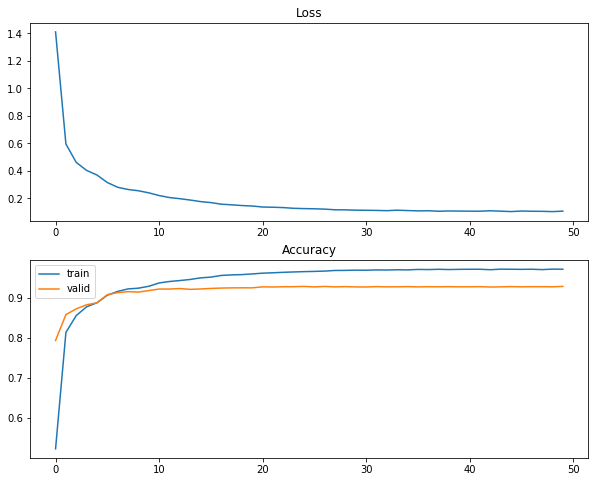

In [113]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8))
ax[0].plot(loss_history)
ax[1].plot(train_history, label='train')
ax[1].plot(val_history, label='valid')
ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
plt.legend()
plt.show()

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [114]:
# TODO Write the code to compute accuracy on test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=BATCH_SIZE, num_workers=8)
test_accuracy = compute_accuracy(nn_model, test_loader, True)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.9288
